# Direct Purchase Prediction Analysis

This notebook compares the accuracy of the `DirectPurchasePredictionModel` for predicting `d100` proceeds against using a `d100/d8` multiplier based on product ratios, specifically for `d0_purchase` users.

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting styles
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Import the DirectPurchasePredictionModel
from direct_purchase_predictions import DirectPurchasePredictionModel

# Import Snowflake connection
from snowflake.snowpark import Session
import config

# Import data utilities
from data_utils import split_data_by_user_type, split_data_by_date

## Connect to Snowflake and Load Data

In [9]:
# Create a Snowflake session
def get_snowflake_session():
    connection_parameters = {
        "account": config.SNOWFLAKE_ACCOUNT,
        "user": config.SNOWFLAKE_USER,
        "role": config.SNOWFLAKE_ROLE,
        "warehouse": config.SNOWFLAKE_WAREHOUSE,
        "database": config.SNOWFLAKE_DATABASE,
        "schema": config.SNOWFLAKE_SCHEMA,
        "authenticator": config.SNOWFLAKE_AUTHENTICATOR
    }
    session = Session.builder.configs(connection_parameters).create()
    print(f"Connected to Snowflake as {config.SNOWFLAKE_USER}")
    return session

session = get_snowflake_session()

# Query the input data
query = """
SELECT *
FROM BLINKIST_DEV.DBT_MJAAMA.EXP_PROCEEDS_INPUT
WHERE REPORT_DATE >= DATEADD(day, -365, CURRENT_DATE())
"""


input_df = session.sql(query).to_pandas()
input_df.columns = input_df.columns.str.lower()
input_df['signup_date'] = pd.to_datetime(input_df['report_date'])

print(f"Loaded {len(input_df):,} input records")

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://blinkist-useast_1_virginia.snowflakecomputing.com/console/login?login_name=meri-kris.jaama%40go1.com&browser_mode_redirect_port=62031&proof_key=VHUROJH8oXzWNFZgHnrrIXhTsSr7kEufwfTaI%2FYc4oY%3D to authenticate...
Connected to Snowflake as meri-kris.jaama@go1.com
Loaded 3,078,822 input records


## Filter for d0_purchase Users and Split Data

In [13]:
from country_utils import add_signup_country_group

# Use data_utils to split data by user type
_, d0_purchase_df, _ = split_data_by_user_type(input_df)

# Add country groups
d0_purchase_df = add_signup_country_group(d0_purchase_df)

# Use data_utils to split data by date
inference_date = (d0_purchase_df['signup_date'].max() - timedelta(days=100)).strftime('%Y-%m-%d')
inference_df, training_d8_df, training_d100_df = split_data_by_date(d0_purchase_df, inference_date)

print(f"Training data: {len(training_d100_df)} records")
print(f"Inference data: {len(inference_df)} records")

/Users/meri-kris/Documents/GitHub/blinkist-expected-proceeds/country_utils.py:37: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  us_df = temp_df.loc[(temp_df.report_date >= six_months_ago) & (temp_df.signup_country == "US") & (
/Users/meri-kris/Documents/GitHub/blinkist-expected-proceeds/country_utils.py:54: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  row_df = temp_df.loc[(temp_df.report_date >= six_months_ago) & (


Training data: 23748 records
Inference data: 1766 records


## Calculate Product d100/d8 Ratios

In [14]:
# Calculate d100/d8 ratio for each product
product_agg = training_d100_df.groupby('product_name').agg({
    'eur_proceeds_d8': 'sum',
    'eur_proceeds_d100': 'sum'
}).reset_index()

# Calculate the ratio
product_agg['d100_to_d8_ratio'] = product_agg['eur_proceeds_d100'] / product_agg['eur_proceeds_d8'].replace(0, np.nan)

# Display the calculated ratios
print("Calculated d100/d8 Ratios:")
display(product_agg[['product_name', 'd100_to_d8_ratio']])

Calculated d100/d8 Ratios:


,product_name,d100_to_d8_ratio
0,2023.apple.premium.12m.no_trial.v1,0.980783
1,2023.apple.premium.12m.trial.v1,1.000000
2,2023.apple.premium.1m.no_trial.v1,2.218427
3,2023.google.premium.12m.no_trial.v1,0.987590
4,2023.google.premium.12m.trial.v1,1.000000
...,...,...
63,recurly_subscription_12m_40_trial_7,1.000000
64,recurly_subscription_12m_70_trial_7,0.991106
65,recurly_subscription_12m_80_trial_7,0.995052
66,recurly_subscription_12m_90_trial_7,0.992848


## Train the Model

In [15]:
# Initialize and train the model
model = DirectPurchasePredictionModel()
model.fit(training_d100_df=training_d100_df)

## Make Predictions

In [16]:
# Make predictions using the model
predictions_df = model.predict(inference_df)

Direct model: Found 321 cases where D100 < D8. Fixing...


## Calculate d100 Using Product d100/d8 Ratio

In [21]:
# Merge with inference data to get the ratio for each product
inference_with_ratios = inference_df.merge(product_agg[['product_name', 'd100_to_d8_ratio']], on='product_name', how='left')

# Calculate d100 using the d100/d8 ratio

inference_with_ratios['calculated_d100'] = inference_with_ratios['eur_proceeds_d0'] * inference_with_ratios['d100_to_d8_ratio']
inference_with_ratios['calculated_d100'].fillna(inference_with_ratios['eur_proceeds_d0'], inplace=True)
inference_with_ratios.head(10)

,report_date,channel_group,marketing_network_id,account_id,campaign_name,campaign_id,adgroup_name,adgroup_id,target_market,eur_marketing_spend,...,space_user,space_owner,space_added_title,eur_proceeds_d0,eur_proceeds_d8,eur_proceeds_d100,signup_date,signup_country_group,d100_to_d8_ratio,calculated_d100
0,2024-12-01,display_and_programmatic,uac,4190078950,UAC_tROAS_High-Value,20906726572,None,None,row,3891.531046,...,0,0,0,8.630000,8.630000,8.630000,2024-12-01,de_at,NaN,8.630000
1,2024-12-01,display_and_programmatic,uac,6277818731,UAC_US_CA_Jan24,20901003728,None,None,us,0.000000,...,0,0,0,10.285971,10.285971,10.285971,2024-12-01,other,NaN,10.285971
2,2024-12-01,display_and_programmatic,uac,6277818731,UAC_ACi_tCPA_Android_GA4F_PurchaseCompleted_OIL,18668550643,None,None,row,0.000000,...,0,0,0,14.507391,14.507391,14.507391,2024-12-01,row_veryhigh,1.0,14.507391
3,2024-12-01,display_and_programmatic,appiness,AppinessxUA2,Blinkist_iOS_532a,unknown,None,None,row,1700.000000,...,0,0,0,1.497693,1.497693,1.497693,2024-12-01,de_at,NaN,1.497693
4,2024-12-01,display_and_programmatic,appiness,AppinessxUA2,Blinkist_iOS_532a,unknown,None,None,row,1700.000000,...,0,0,0,8.186932,8.186932,8.186932,2024-12-01,gb_ca_au,NaN,8.186932
5,2024-12-01,display_and_programmatic,appiness,AppinessxUA2,BlinkistiOS_638a,unknown,None,None,row,200.000000,...,0,0,0,7.189720,7.189720,7.189720,2024-12-01,de_at,NaN,7.189720
6,2024-12-01,display_and_programmatic,appiness,AppinessxUA2,Blinkist_iOS_642b,unknown,None,None,row,250.000000,...,0,0,0,7.189720,7.189720,7.189720,2024-12-01,de_at,NaN,7.189720
7,2024-12-01,display_and_programmatic,applovin,unknown,Blinkist_iOS_CPP,b5a20e00bbc4f3daf8f6e9cb6bba5d54,None,None,row,1894.908440,...,0,0,0,6.651855,6.651855,6.651855,2024-12-01,gb_ca_au,NaN,6.651855
8,2024-12-01,display_and_programmatic,applovin,unknown,Blinkist_iOS_CPP,b5a20e00bbc4f3daf8f6e9cb6bba5d54,None,None,row,1894.908440,...,0,0,0,83.880722,83.880722,83.880722,2024-12-01,gb_ca_au,1.0,83.880722
9,2024-12-01,display_and_programmatic,smadex,unknown,blinkist_ios_de_smadex,unknown,None,None,row,0.000000,...,0,0,0,7.189720,7.189720,7.189720,2024-12-01,de_at,NaN,7.189720


## Compare Model Predictions with Ratio-Based Predictions

In [22]:
# Calculate mean squared error for both methods
mse_model = mean_squared_error(inference_df['eur_proceeds_d100'], predictions_df['expected_proceeds_d100'])
mse_ratio = mean_squared_error(inference_df['eur_proceeds_d100'], inference_with_ratios['calculated_d100'])

print(f"Model MSE: {mse_model}")
print(f"Ratio-Based MSE: {mse_ratio}")

Model MSE: 73.70054430710277
Ratio-Based MSE: 33.18250046959319


## Visualize the Results

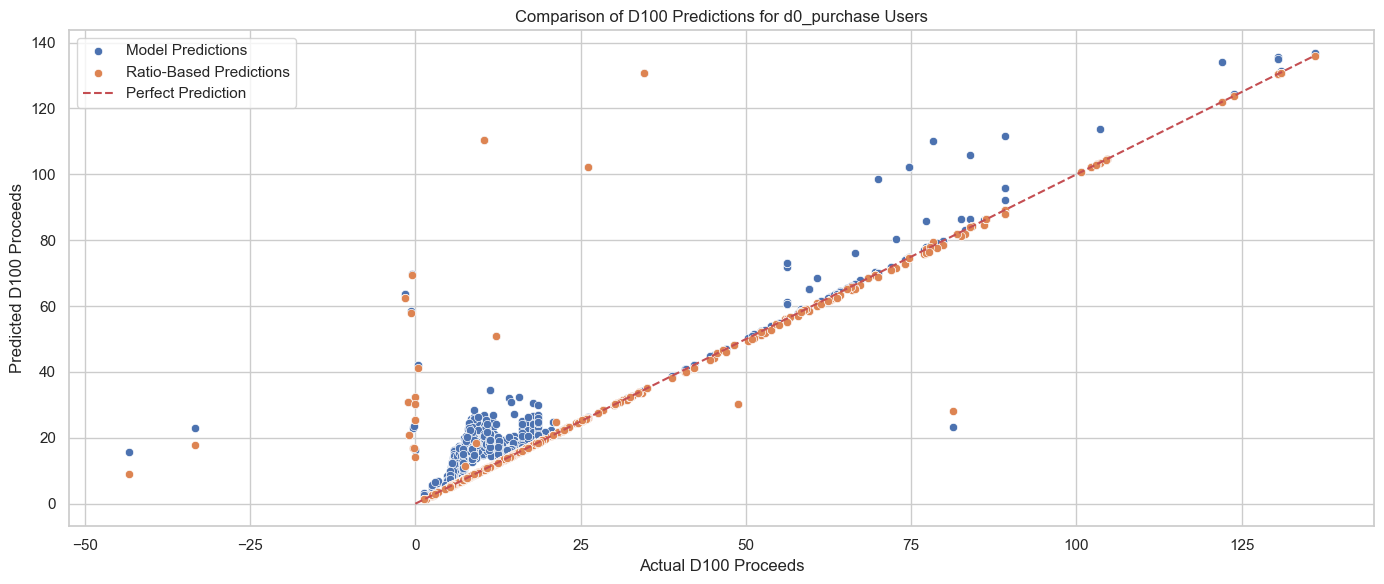

In [24]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 6))
sns.scatterplot(x='eur_proceeds_d100', y='expected_proceeds_d100', data=predictions_df, label='Model Predictions')
sns.scatterplot(x='eur_proceeds_d100', y='calculated_d100', data=inference_with_ratios, label='Ratio-Based Predictions')
plt.plot([0, max(inference_df['eur_proceeds_d100'])], [0, max(inference_df['eur_proceeds_d100'])], 'r--', label='Perfect Prediction')
plt.title('Comparison of D100 Predictions for d0_purchase Users')
plt.xlabel('Actual D100 Proceeds')
plt.ylabel('Predicted D100 Proceeds')
plt.legend()
plt.tight_layout()
plt.show()